In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv(r"C:\Users\luiz\Documents\GitHub\DailyML\Housing Prices\train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Quais os objetivos dessa Análise? 
1. Identificar quais as variáveis que melhor explicam a variação do preço das casas
2. Criar um modelo de regressão que prevê o valor das casas
3. Criar um modelo que identifica se uma casa é uma anomalia com base no restante dos dados (Ad-malicioso, por exemplo)
4. Identificar casas com valores abaixo do valor do mercado

Quais variáveis explicam melhor a variação do preço das casas? 

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class DropAndRenameColumns(BaseEstimator, TransformerMixin):

    def __init__(self, drop_cols=None, rename_map=None):

        self.drop_cols = drop_cols or []

        self.rename_map = rename_map or {}

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        X_ = X.copy()

        if self.drop_cols:

            X_ = X_.drop(columns=self.drop_cols, errors="ignore")

        if self.rename_map:

            X_ = X_.rename(columns=self.rename_map)

        return X_

In [5]:
# Mapping utilizado com base em reposta de IA para tornar os nomes mais descritivos:
value_mapping = {
    # Road and Alley Surfaces
    "Grvl": "Gravel",
    "Pave": "Paved",
    "NA": "No Access",  # Used for alleys and basements
    # Lot Shape
    "Reg": "Regular",
    "IR1": "Slightly Irregular",
    "IR2": "Moderately Irregular",
    "IR3": "Irregular",
    # Land Contour
    "Lvl": "Near Flat/Level",
    "Bnk": "Banked",
    "HLS": "Hillside",
    "Low": "Depression",
    # Utilities
    "AllPub": "All Public Utilities",
    "NoSewr": "No Sewer (Septic Tank)",
    "NoSeWa": "No Sewer or Water",
    "ELO": "Electricity Only",
    # Lot Config
    "Inside": "Inside Lot",
    "Corner": "Corner Lot",
    "CulDSac": "Cul-de-sac",
    "FR2": "Frontage on 2 Sides",
    "FR3": "Frontage on 3 Sides",
    # Land Slope
    "Gtl": "Gentle Slope",
    "Mod": "Moderate Slope",
    "Sev": "Severe Slope",
    # Condition (Condition1 & Condition2)
    "Artery": "Adjacent to Arterial Street",
    "Feedr": "Adjacent to Feeder Street",
    "Norm": "Normal",
    "RRNn": "Near N-S Railroad",
    "RRAn": "Adjacent to N-S Railroad",
    "RRNe": "Near E-W Railroad",
    "RRAe": "Adjacent to E-W Railroad",
    "PosN": "Near Positive Off-site Feature",
    "PosA": "Adjacent to Positive Off-site Feature",
    # Building Type
    "1Fam": "Single-family Detached",
    "2FmCon": "Two-family Conversion",
    "Duplx": "Duplex",
    "TwnhsE": "Townhouse End Unit",
    "TwnhsI": "Townhouse Inside Unit",
    # House Style
    "1Story": "One Story",
    "1.5Fin": "One and Half Story Finished",
    "1.5Unf": "One and Half Story Unfinished",
    "2Story": "Two Story",
    "2.5Fin": "Two and Half Story Finished",
    "2.5Unf": "Two and Half Story Unfinished",
    "SFoyer": "Split Foyer",
    "SLvl": "Split Level",
    # Quality and Condition Ratings
    "Ex": "Excellent",
    "Gd": "Good",
    "TA": "Typical/Average",
    "Fa": "Fair",
    "Po": "Poor",
    # Basement Specific
    "Av": "Average Exposure",
    "Mn": "Minimum Exposure",
    "No": "No Exposure",
    "GLQ": "Good Living Quarters",
    "ALQ": "Average Living Quarters",
    "BLQ": "Below Average Living Quarters",
    "Rec": "Recreation Room",
    "LwQ": "Low Quality",
    "Unf": "Unfinished",
    # Heating
    "Floor": "Floor Furnace",
    "GasA": "Gas Forced Warm Air",
    "GasW": "Gas Hot Water or Steam",
    "Grav": "Gravity Furnace",
    "OthW": "Other Water Heater",
    "Wall": "Wall Furnace",
    # Central Air
    "Y": "Yes",
    "N": "No",
    # Electrical
    "SBrkr": "Standard Circuit Breakers",
    "FuseA": "Fuse Box >60AMP + Romex",
    "FuseF": "60AMP Fuse Box + Mostly Romex",
    "FuseP": "60AMP + Mostly Knob & Tube",
    "Mix": "Mixed Wiring",
    # Kitchen Quality
    # Already mapped above: Ex, Gd, TA, Fa, Po
    # Functional
    "Typ": "Typical Functionality",
    "Min1": "Minor Deductions 1",
    "Min2": "Minor Deductions 2",
    "Mod": "Moderate Deductions",
    "Maj1": "Major Deductions 1",
    "Maj2": "Major Deductions 2",
    "Sev": "Severely Damaged",
    "Sal": "Salvage Only",
    # Fireplace Quality
    # Already mapped above: Ex, Gd, TA, Fa, Po, NA
    # Garage Type
    "2Types": "More than One Type",
    "Attchd": "Attached",
    "Basment": "Basement",
    "BuiltIn": "Built-In",
}

map_zoneamento = {
    "A": "Agriculture",
    "C": "Commercial",
    "FV": "Floating Village Residential",
    "I": "Industrial",
    "RH": "Residential High Density",
    "RL": "Residential Low Density",
    "RP": "Residential Low Density Park ",
    "RM": "Residential Medium Density",
}

In [6]:
train.replace(value_mapping, inplace=True)

In [7]:
train["MSZoning"] = train["MSZoning"].replace(map_zoneamento)

In [8]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,Residential Low Density,65.0,8450,Paved,NaN,Regular,Near Flat/Level,All Public Utilities,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,Residential Low Density,80.0,9600,Paved,NaN,Regular,Near Flat/Level,All Public Utilities,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,Residential Low Density,68.0,11250,Paved,NaN,Slightly Irregular,Near Flat/Level,All Public Utilities,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,Residential Low Density,60.0,9550,Paved,NaN,Slightly Irregular,Near Flat/Level,All Public Utilities,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,Residential Low Density,84.0,14260,Paved,NaN,Slightly Irregular,Near Flat/Level,All Public Utilities,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Verificando Distribuição de preço de acordo com boxplots. Criando uma função que permita visualizar os dados de acordo com os valores únicos.

In [ ]:
import pandas as pd
from scipy.stats import ttest_1samp
import numpy as np
import seaborn as sns


def tabela_de_frequencia(df, col, col_target):
    """
    Gera um DataFrame com:
    - Frequência absoluta
    - Frequência relativa (%)
    - Estatísticas de col_target (média, mediana, std, min, max, Q1, Q3)

    Args:
        df (pd.DataFrame): DataFrame de entrada
        col (str): Nome da coluna categórica a ser analisada

    Returns:
        pd.DataFrame: Tabela resumo com frequências e estatísticas de posição e dispersão
    """

    frequencias = df[col].value_counts(dropna=False)
    frequencias_rel = df[col].value_counts(normalize=True, dropna=False) * 100

    # Estatísticas de SalePrice por categoria
    estatisticas = df.groupby(col)[col_target].agg(
        q25=lambda x: x.quantile(0.25),
        media="mean",
        mediana="median",
        desvio_padrao="std",
        q75=lambda x: x.quantile(0.75),
        maximo="max",
    )

    tabela = pd.DataFrame(
        {
            col: frequencias.index,
            "Frequência Absoluta": frequencias.values,
            "Frequência Relativa (%)": frequencias_rel.values,
        }
    ).set_index(col)

    tabela = tabela.join(estatisticas)
    tabela = tabela.round(2)

    return tabela.reset_index()


def visualizacao_box_plot(df, col, col_target):
    """
    Gera um boxplot para a coluna col comparando com SalePrice.

    Parâmetros:
    - df: DataFrame pandas contendo os dados
    - col: string, nome da coluna categórica a ser usada no eixo X
    """
    plt.figure(figsize=(8, 6))
    n_categorias = df[col].nunique()
    sns.violinplot(data=df, x=col, y=col_target, hue=col, legend=False)
    plt.title(f"Boxplot de SalePrice por {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### A classifação da área Impacta no preço do empreendimento?

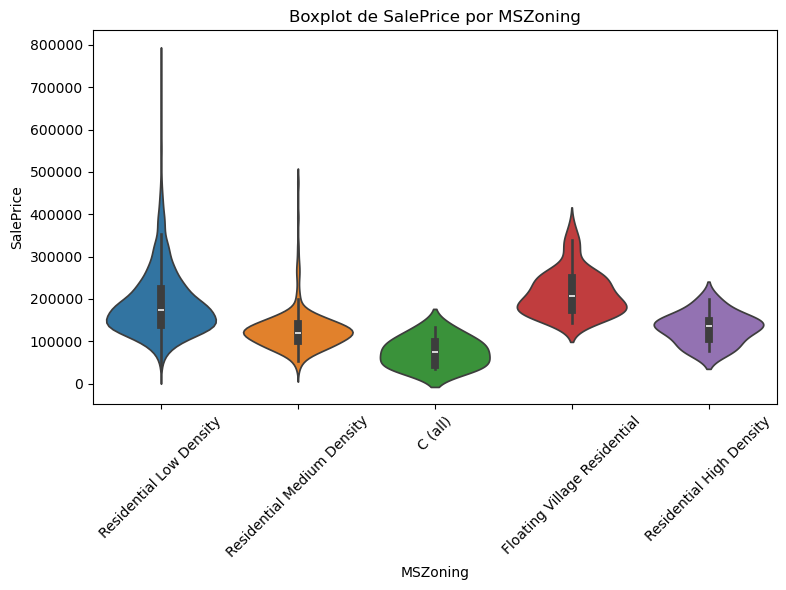

In [ ]:
visualizacao_box_plot(train, "MSZoning", "SalePrice")

In [ ]:
tabela_de_frequencia(train, "MSZoning", "SalePrice")

,MSZoning,Frequência Absoluta,Frequência Relativa (%),q25,media,mediana,desvio_padrao,q75,maximo
0,Residential Low Density,1151,78.84,137700.00,191004.99,174000.0,80766.34,224700.0,755000
1,Residential Medium Density,218,14.93,100000.00,126316.83,120500.0,48521.69,140000.0,475000
2,Floating Village Residential,65,4.45,174000.00,214014.06,205950.0,52369.66,250000.0,370878
3,Residential High Density,16,1.10,106150.00,131558.38,136500.0,35714.12,148608.5,200000
4,C (all),10,0.68,43998.25,74528.00,74700.0,33791.09,98332.0,133900


#### Principais pontos da Zona:
1. O dataset é composto majoritariamente por partes residenciais de baixa densidade.
2. O Conjunto de baixa densidade possui um número alto de dispersão, com o maior desvio padrão entre as séries, isso provavelmente se deve ao fato que tanto residências em locais de pouca habitação como regiões mais rurais e regiões mais ricas onde o número de casas é menor devido a extensão das casas pode explicar esse fato.
3. Podemos fazer uma verificação do tamanho das casas em cada MSZoning para verificar se existe essa relação, dado que casas mais caras podem ser casas maiores, o que causaria o aumento do preço.

Para verificar isso, podemos identificar a distribuição de tamanho de casas para casa tipo de zona

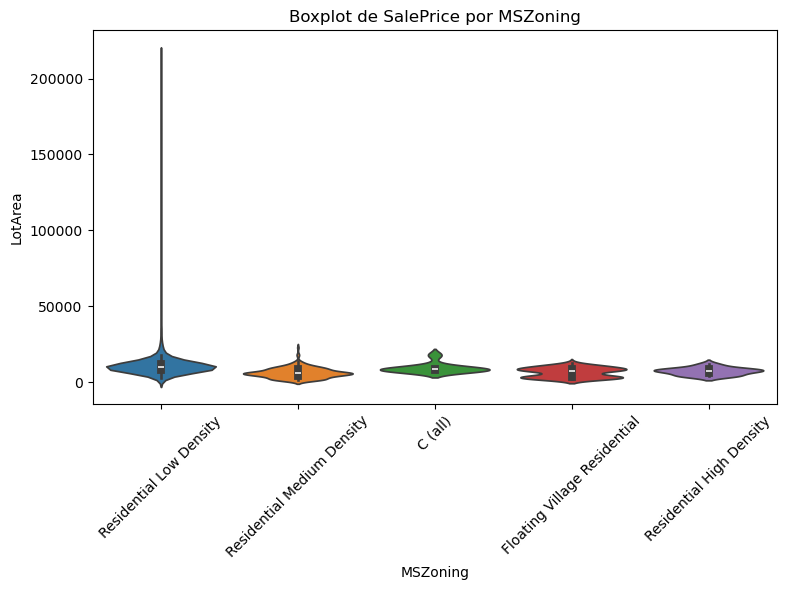

In [ ]:
visualizacao_box_plot(train, "MSZoning", "LotArea")

Como esperado, as residências em regiões de baixa densidade também contém os outliers em relação com tamanho residencial. Com relação a distribuição de residências com baixa residência, é estimado que 45% da área de Ames é relacionada com residências de unifamiliares, que geralmente são classificadas como baixa densidade residencial.
[Referência: Zoneamento de Ames, Iowa](https://www.zoneomics.com/zoning-maps/iowa/ames?utm_source=chatgpt.com)

Entretanto, considerando o exposto, podemos tentar entender o preço da residência de acordo com o tamanho de sua região, vamos verificar isso com um gráfico de correlação entre preço e tamanho da área e verificar como se distribuem de acordo com o Zoneamento

coeficiente:
 [2.09997195]
intercept: 
 158836.1518968766
mean_square_error: 
 5867752122.51
coeficiente de determinação: 
 0.0696133153821119


Text(0.5, 0, 'LotArea')

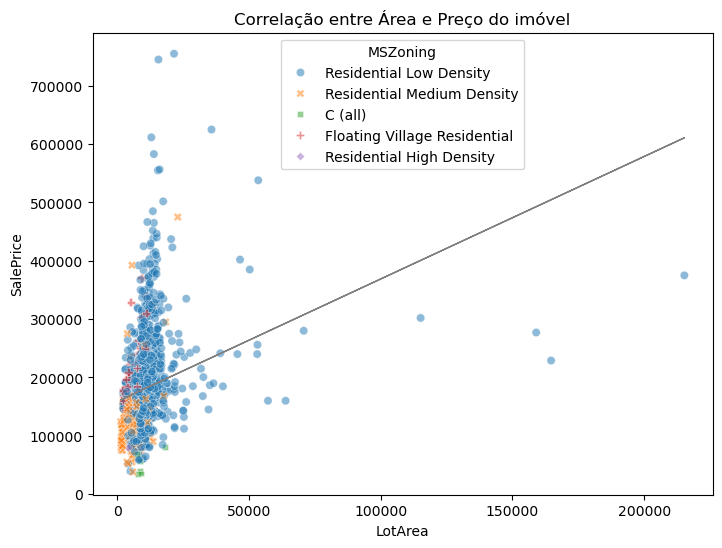

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

modelo = LinearRegression()

X = train[["LotArea"]]
y = train["SalePrice"]

modelo.fit(X, y)

previsto = modelo.predict(X)

coeficiente_com_outliers = modelo.coef_
print("coeficiente:\n", modelo.coef_)
intercept_com_outliers = modelo.intercept_
print("intercept: \n", intercept_com_outliers)
mse_com_outliers = round(mean_squared_error(y, previsto), 2)
print("mean_square_error: \n", mse_com_outliers)
r2_com_outliers = r2_score(y, previsto)
print("coeficiente de determinação: \n", r2_com_outliers)

plt.figure(figsize=(8, 6))
plt.title("Correlação entre Área e Preço do imóvel")
sns.scatterplot(
    train, x="LotArea", y="SalePrice", hue="MSZoning", alpha=0.5, style="MSZoning"
)
plt.plot(X, previsto, color="gray", linewidth=1)
plt.ylabel("SalePrice")
plt.xlabel("LotArea")

A correlação demonstra um fato interessante: Temos poucas residências com mais de 100000 de área de M^2, isso é um fato importante para determinar se devemos ou não manter esses dados na distribuição, para verificar essa informação, vamos verificar o percentual e frequência total das residências com base em tamanho de residência e Valor de Venda, e então, vamos considerar rodar ele novamente e comparar os resultados da regressão linear

In [ ]:
price_category_bins = list(range(0, 800000 + 1, 100000))
Lot_area_category_bins = list(range(0, 250000 + 1, 50000))

train["cat_area"] = pd.cut(train["LotArea"], bins=Lot_area_category_bins)
train["cat_price"] = pd.cut(train["SalePrice"], bins=price_category_bins)

freq_area = tabela_de_frequencia(train, "cat_area", "SalePrice")
freq_price = tabela_de_frequencia(train, "cat_price", "LotArea")

C:\Users\luiz\AppData\Local\Temp\ipykernel_14012\517237203.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  estatisticas = df.groupby(col)[col_target].agg(
C:\Users\luiz\AppData\Local\Temp\ipykernel_14012\517237203.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  estatisticas = df.groupby(col)[col_target].agg(


In [70]:
freq_area.head(10)

,cat_area,Frequência Absoluta,Frequência Relativa (%),q25,media,mediana,desvio_padrao,q75,maximo
0,"(0, 50000]",1449,99.25,129900.0,180084.88,162900.0,78636.78,213000.0,755000
1,"(50000, 100000]",7,0.48,200000.0,288428.57,256000.0,134206.13,332500.0,538000
2,"(150000, 200000]",2,0.14,240962.5,252975.00,252975.0,33976.48,264987.5,277000
3,"(100000, 150000]",1,0.07,302000.0,302000.00,302000.0,NaN,302000.0,302000
4,"(200000, 250000]",1,0.07,375000.0,375000.00,375000.0,NaN,375000.0,375000


In [71]:
freq_price.head(10)

,cat_price,Frequência Absoluta,Frequência Relativa (%),q25,media,mediana,desvio_padrao,q75,maximo
0,"(100000, 200000]",910,62.33,7200.00,9348.34,8985.5,4753.78,10751.75,63887
1,"(200000, 300000]",312,21.37,9100.00,12991.71,10765.0,13754.95,13125.00,164660
2,"(0, 100000]",123,8.42,5116.00,7110.35,7200.0,3416.28,9000.00,18000
3,"(300000, 400000]",87,5.96,10552.00,16153.40,12099.0,24738.75,14050.00,215245
4,"(400000, 500000]",19,1.30,13085.00,16426.68,13891.0,8006.96,15057.50,46589
5,"(500000, 600000]",5,0.34,15431.00,23261.00,16056.0,16953.90,17423.00,53504
6,"(600000, 700000]",2,0.14,18629.25,24339.50,24339.5,16151.03,30049.75,35760
7,"(700000, 800000]",2,0.14,17101.00,18579.00,18579.0,4180.42,20057.00,21535


Em torno de 99,4% das casas possuem até U$ 500.000 de preço e tem uma área de até 50.000 m², vamos realizar a comparação retirando esses outliers

coeficiente:
 [5.65083207]
intercept: 
 122172.91206438708
mean_square_error: 
 4459547041.05
coeficiente de determinação: 
 0.0696133153821119


Modelo,Com Outliers,Sem Outliers,diff_bruta,diff_percentual
MSE,5867752122.51,4459547041.05,1408205081.46,-0.239991
R2,0.069613,0.127303,0.057689,0.828711
Coef,[2.0999719517076727],[5.650832069384011],[3.550860117676338],[1.6909083546515085]
Intercept,158836.151897,122172.912064,36663.239832,-0.230824


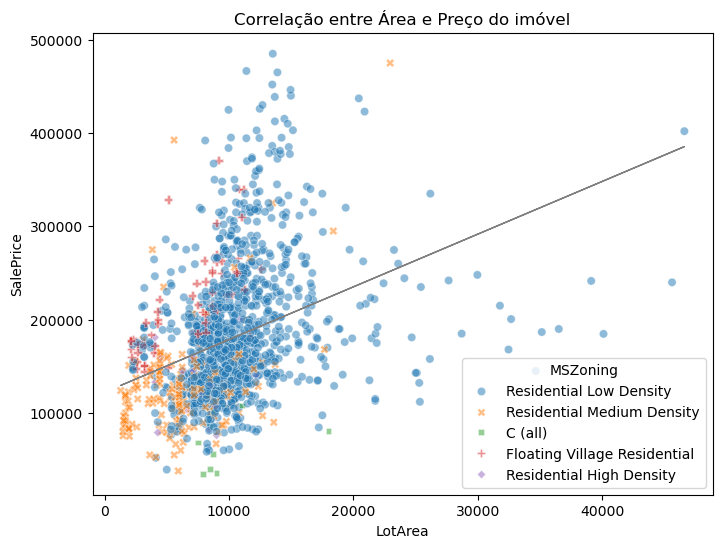

In [ ]:
## Testando versão sem outliers

teste_de_filtro = train[(train["LotArea"] <= 50000) & (train["SalePrice"] <= 500000)]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

modelo = LinearRegression()

X = teste_de_filtro[["LotArea"]]
y = teste_de_filtro["SalePrice"]

modelo.fit(X, y)

previsto = modelo.predict(X)

# Coeficiente
coeficiente_sem_outliers = modelo.coef_
print("coeficiente:\n", coeficiente_sem_outliers)
intercept_sem_outliers = modelo.intercept_
print("intercept: \n", intercept_sem_outliers)
mse_sem_outliers = round(mean_squared_error(y, previsto), 2)
print("mean_square_error: \n", mse_sem_outliers)
r2_sem_outliers = r2_score(y, previsto)
print("coeficiente de determinação: \n", r2_com_outliers)

plt.figure(figsize=(8, 6))
plt.title("Correlação entre Área e Preço do imóvel")
sns.scatterplot(
    teste_de_filtro,
    x="LotArea",
    y="SalePrice",
    hue="MSZoning",
    alpha=0.5,
    style="MSZoning",
)
plt.plot(X, previsto, color="gray", linewidth=1)
plt.ylabel("SalePrice")
plt.xlabel("LotArea")

dataframe_de_comparação = pd.DataFrame(
    {
        "Modelo": ["Com Outliers", "Sem Outliers"],
        "MSE": [mse_com_outliers, mse_sem_outliers],
        "R2": [r2_com_outliers, r2_sem_outliers],
        "Coef": [coeficiente_com_outliers, coeficiente_sem_outliers],
        "Intercept": [intercept_com_outliers, intercept_sem_outliers],
    }
)

dataframe_de_comparação_pivot = dataframe_de_comparação.set_index("Modelo").T
dataframe_de_comparação_pivot["diff_bruta"] = abs(
    dataframe_de_comparação_pivot["Com Outliers"]
    - dataframe_de_comparação_pivot["Sem Outliers"]
)
dataframe_de_comparação_pivot["diff_percentual"] = round(
    (
        dataframe_de_comparação_pivot["Sem Outliers"]
        / dataframe_de_comparação_pivot["Com Outliers"]
    )
    - 1,
    2,
)
dataframe_de_comparação_pivot.head()